In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import glob

import pickle as pkl
import yaml

from pyoperators import *
from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator

import qubic
from FMM.pipeline import PipelineFrequencyMapMaking
import lib.Qacquisition as acquisition
from FMM.model.planck_timeline import ExternalData2Timeline

%matplotlib inline

# Nsub_in

In [2]:
def get_dict(params, comm, key='in'):
    """QUBIC dictionary.

    Method to modify the qubic dictionary.

    Parameters
    ----------
    key : str, optional
        Can be "in" or "out".
        It is used to build respectively the instances to generate the TODs or to reconstruct the sky maps,
        by default "in".

    Returns
    -------
    dict_qubic: dict
        Modified QUBIC dictionary.

    """

    args = {
        "npointings": params["QUBIC"]["npointings"],
        "nf_recon": params["QUBIC"]["nrec"],
        "nf_sub": params["QUBIC"][f"nsub_{key}"],
        "nside": params["SKY"]["nside"],
        "MultiBand": True,
        "period": 1,
        "RA_center": params["SKY"]["RA_center"],
        "DEC_center": params["SKY"]["DEC_center"],
        "filter_nu": 150 * 1e9,
        "noiseless": False,
        "comm": comm,
        "dtheta": params["QUBIC"]["dtheta"],
        "nprocs_sampling": 1,
        "nprocs_instrument": comm.Get_size(),
        "photon_noise": True,
        "nhwp_angles": 3,
        #'effective_duration':3,
        "effective_duration150": 3,
        "effective_duration220": 3,
        "filter_relative_bandwidth": 0.25,
        "type_instrument": "wide",
        "TemperatureAtmosphere150": None,
        "TemperatureAtmosphere220": None,
        "EmissivityAtmosphere150": None,
        "EmissivityAtmosphere220": None,
        "detector_nep": float(params["QUBIC"]["NOISE"]["detector_nep"]),
        "synthbeam_kmax": params["QUBIC"]["SYNTHBEAM"]["synthbeam_kmax"],
    }

    ### Get the default dictionary
    dictfilename = "dicts/pipeline_demo.dict"
    dict_qubic = qubic.qubicdict.qubicDict()
    dict_qubic.read_from_file(dictfilename)

    for i in args.keys():

        dict_qubic[str(i)] = args[i]

    return dict_qubic

In [3]:
def get_sky_config(params, comm):
        """Sky configuration.

        Method that read 'params.yml' file and create dictionary containing sky emission model.

        Returns
        -------
        dict_sky: dict
            Sky config dictionary.

        Notes
        -----
        Note that the key denote the emission and the value denote the sky model using PySM convention.
        For CMB, seed denote the realization.

        Example
        -------
        d = {'cmb':seed, 'dust':'d0', 'synchrotron':'s0'}

        """

        dict_sky = {}

        if params["CMB"]["cmb"]:
            if params["CMB"]["seed"] == 0:
                if comm.Get_rank() == 0:
                    seed = np.random.randint(10000000)
                else:
                    seed = None
                seed = comm.bcast(seed, root=0)
            else:
                seed = params["CMB"]["seed"]
                
            dict_sky["cmb"] = seed

        for j in params["Foregrounds"]:
            # print(j, params['Foregrounds'][j])
            if j == "Dust":
                if params["Foregrounds"][j]:
                    dict_sky["dust"] = "d0"
            elif j == "Synchrotron":
                if params["Foregrounds"][j]:
                    dict_sky["synchrotron"] = "s0"

        return dict_sky

In [4]:
# Initialize pipeline arguments
comm = MPI.COMM_WORLD

file = '/pbs/home/t/tlaclave/sps/Pipeline/src/Nsub_in'

with open('/pbs/home/t/tlaclave/sps/Pipeline/src/Nsub_in/params.yml', 'r') as file:
    params = yaml.safe_load(file)

In [5]:
# Acquisition arguments
dict_qubic = get_dict(params, comm)
sampling=qubic.get_pointing(dict_qubic)
nsub_list = np.arange(4, 52, 2)

You asked 1000 pointings with repeat strategy so I will provide 333 pointings repeated 3 times.


In [6]:
sky = get_sky_config(params, comm)

In [7]:
TOD_list = []
TOD_ones_list = []
for isub in nsub_list:
    TOD = []
    TOD_ones = []
    acq = acquisition.QubicMultiAcquisitions(dict_qubic, isub, params['QUBIC']['nrec'], sampling=sampling)
    ext = ExternalData2Timeline(sky, acq.allnus, params['QUBIC']['nrec'], params['SKY']['nside'])
    
    H = acq.H
    input_maps = ext.m_nu
    input_maps_ones = np.ones(np.shape(input_maps))
    
    for i in range(isub):
        C = HealpixConvolutionGaussianOperator(acq.allfwhm[i])
        TOD.append(H[i](C(input_maps[i])))
        TOD_ones.append(H[i](C(input_maps_ones[i])))
    TOD_list.append(np.sum(TOD, axis=0))
    TOD_ones_list.append(np.sum(TOD_ones, axis=0))

Info cca018: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info cca018: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info cca018: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info cca018: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info cca018: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info cca018: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info cca018: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info cca018: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info cca018: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info cca018: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
Info cca01

In [8]:
print(len(TOD_list), TOD_list[0].shape)

24 (992, 999)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Nsub input')

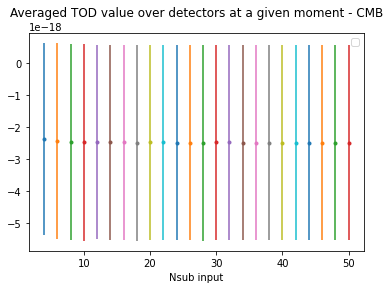

In [28]:
plt.figure()
for i in range(len(nsub_list)):
    plt.errorbar(nsub_list[i], np.mean(TOD_list, axis=1)[i][400], np.std(TOD_list, axis=1)[i][400], fmt='.')#, label=f"Nsub_in = {nsub_list[i]}")
plt.legend()
plt.title('Averaged TOD value over detectors at a given moment - CMB')
plt.xlabel('Nsub input')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Nsub input')

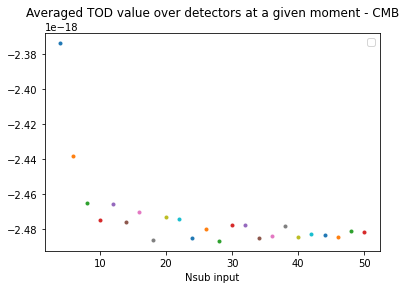

In [27]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.mean(TOD_list[i], axis=0)[400], '.')#, label=f"Nsub_in = {nsub_list[i]}")
plt.legend()
plt.title('Averaged TOD value over detectors at a given moment - CMB')
plt.xlabel('Nsub input')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Nsub input')

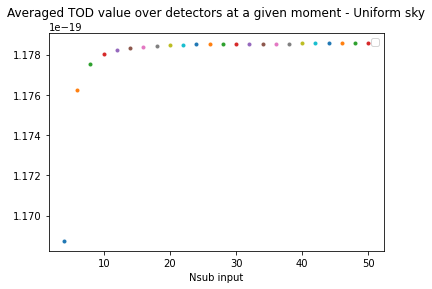

In [26]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.mean(TOD_ones_list[i], axis=0)[400], '.')#, label=f"Nsub_in = {nsub_list[i]}")
plt.legend()
plt.title('Averaged TOD value over detectors at a given moment - Uniform sky')
plt.xlabel('Nsub input')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Nsub input')

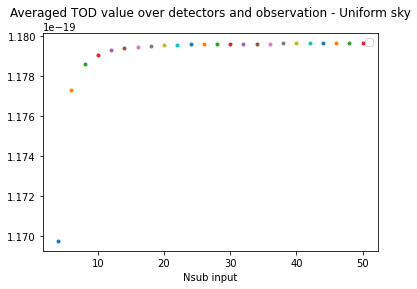

In [25]:
plt.figure()
for i in range(len(nsub_list)):
    plt.plot(nsub_list[i], np.mean(TOD_ones_list[i]), '.')#, label=f"Nsub_in = {nsub_list[i]}")
plt.legend()
plt.title('Averaged TOD value over detectors and observation - Uniform sky')
plt.xlabel('Nsub input')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Nsub input')

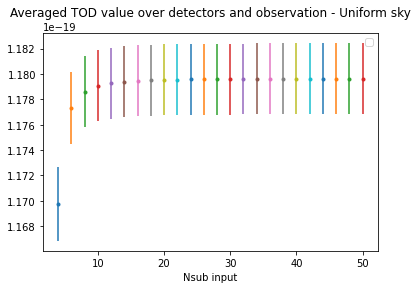

In [33]:
plt.figure()
for i in range(len(nsub_list)):
    plt.errorbar(nsub_list[i], np.mean(TOD_ones_list[i]), np.std(np.mean(TOD_ones_list[i], axis=0))/np.sqrt(2), fmt='.')#, label=f"Nsub_in = {nsub_list[i]}")
plt.legend()
plt.title('Averaged TOD value over detectors and observation - Uniform sky')
plt.xlabel('Nsub input')

6 -7.538105546045305e-22
8 -1.3125139439770127e-22
10 -4.534373187255734e-23
12 -2.0886301876955285e-23
14 -1.1317979940376096e-23
16 -6.815412087346592e-24
18 -4.419432696588005e-24
20 -3.0281140579973906e-24
22 -2.1651256246108167e-24
24 -1.6020307805016856e-24
26 -1.2176543489096795e-24
28 -9.477030303865462e-25
30 -7.518165223851513e-25
32 -6.065879693151358e-25
34 -4.963266637266584e-25
36 -4.1108485905259088e-25
38 -3.449424718091716e-25
40 -2.91483342027573e-25
42 -2.4916346255288405e-25
44 -2.1429975833738945e-25
46 -1.8567838499839758e-25
48 -1.6213705534597626e-25
50 -1.4218243310501352e-25


Text(0.5, 1.0, 'Diference between TOD value')

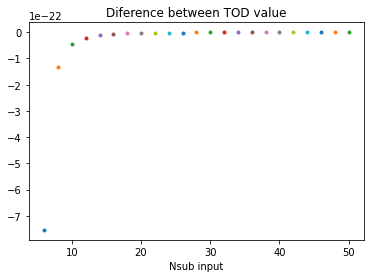

In [32]:
plt.figure()
for i in range(len(nsub_list)-1):
    plt.plot(nsub_list[i+1], np.mean(TOD_ones_list[i]) - np.mean(TOD_ones_list[i+1]), '.')#, label=f"Nsub_in = {nsub_list[i]}")
    print(nsub_list[i+1], np.mean(TOD_ones_list[i]) - np.mean(TOD_ones_list[i+1]))
plt.xlabel('Nsub input')
plt.title('Diference between TOD value')

In [14]:
stop

NameError: name 'stop' is not defined

In [ ]:
# Initialize pipeline arguments
comm = MPI.COMM_WORLD

file = '/pbs/home/t/tlaclave/sps/Pipeline/src/Nsub_in'


In [ ]:
tod_list = []
for isub_in in range(4,20, 2):
    with open('/pbs/home/t/tlaclave/sps/Pipeline/src/Nsub_in/params.yml', 'r') as file:
        params = yaml.safe_load(file)
    params['QUBIC']['nsub_in'] = isub_in
    params['QUBIC']['nsub_out'] = isub_in
    print(isub_in)
    fmm = PipelineFrequencyMapMaking(comm, file, params)
    tod = fmm.get_tod()
    tod_list.append(tod)

4


TypeError: __init__() got an unexpected keyword argument 'nu_co'

In [ ]:
Ndet = 992
Nsamples = 999
tod_reshape = np.reshape(tod_list[0], (2, Ndet, Nsamples))

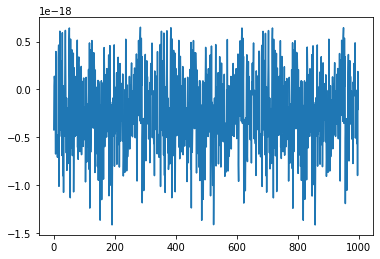

In [ ]:
plt.plot(tod_reshape[0,0])

{'debug': False,
 'config': 'FI',
 'filter_nu': 150000000000.0,
 'filter_relative_bandwidth': 0.25,
 'beam_shape': 'gaussian',
 'MultiBand': True,
 'nf_sub': 18,
 'center_detector': False,
 'psd': None,
 'bandwidth': None,
 'twosided': None,
 'sigma': None,
 'detector_nep': 4.7e-17,
 'detector_fknee': 0,
 'detector_fslope': 1,
 'detector_ncorr': 10,
 'detector_ngrids': 1,
 'detector_tau': 0.01,
 'polarizer': True,
 'synthbeam_fraction': 1.0,
 'synthbeam_kmax': 1,
 'synthbeam_peak150_fwhm': 0.39268176,
 'ripples': False,
 'nripples': 0,
 'focal_length': 0.3,
 'optics': 'CalQubic_Optics_v3_CC_FFF.txt',
 'primbeam': 'CalQubic_PrimBeam_v2.fits',
 'detarray': 'CalQubic_DetArray_v4_CC.fits',
 'hornarray': 'CalQubic_HornArray_CC.fits',
 'synthbeam': 'CalQubic_Synthbeam_Analytical_220_FI.fits',
 'nside': 64,
 'kind': 'IQU',
 'absolute': False,
 'temperature': 2.7255,
 'summer': False,
 'RA_center': 0,
 'DEC_center': -57,
 'period': 1,
 'date_obs': '2016-01-01 00:00:00',
 'latitude': -24.183333